<a href="https://colab.research.google.com/github/Succzzz33/QM_2023/blob/main/qm_group_%E5%9B%9E%E5%BD%92_%EF%BC%8C%E7%9B%B8%E5%85%B3_vif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True)  #作图
df_office.plot(kind='scatter', x='gender', y='wellbeing', ax=axs[0], figsize=(16, 8))
df_office.plot(kind='scatter', x='greenery', y='wellbeing', ax=axs[1])
df_office.plot(kind='scatter', x='light', y='wellbeing', ax=axs[2])

In [34]:
bike_rental = pd.read_csv('https://github.com/huanfachen/QM_2023/raw/main/data/daily_count_rent_bike.csv')
#转成numeric 若有category data
bike_rental_numeric = pd.get_dummies(bike_rental, dtype=int)
bike_rental_final = bike_rental_numeric.drop(['season_SPRING', 'mnth_JAN', 'holiday_NO HOLIDAY', 'weekday_MON', 'workingday_WORKING DAY', 'weathersit_GOOD'], axis=1) #k个  categories 只要K-1个dummy var 每种删一个

<ipython-input-37-6c4a516e4f26>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  bike_rental.corr()


Text(0.5, 1.0, 'Correlation Matrix')

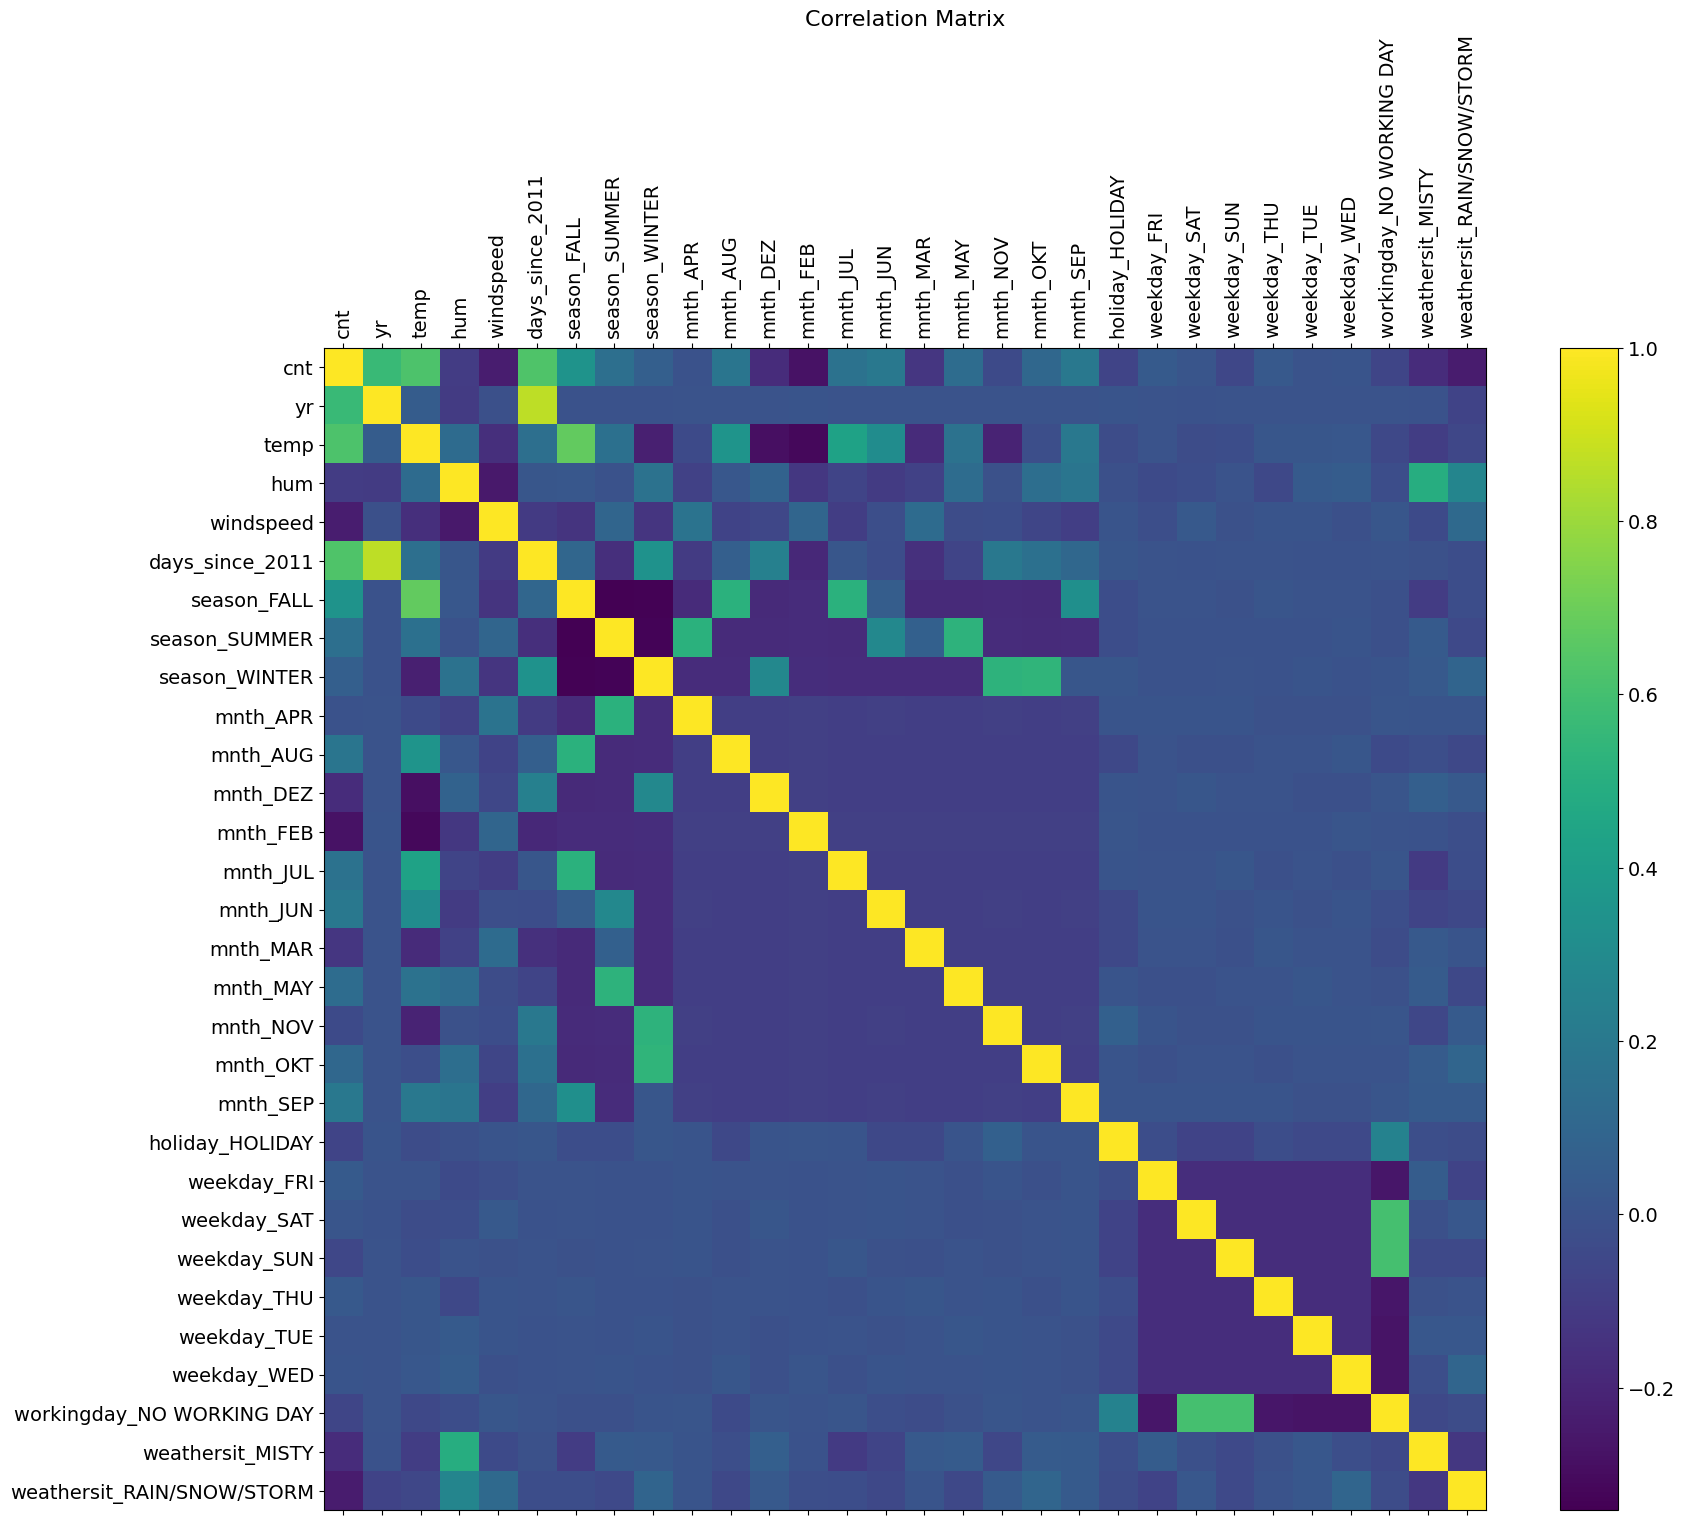

In [37]:
#相关性表
bike_rental.corr()
df = bike_rental_final #相关性图
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)#几格 每个的名字
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar() #legend
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

##回归之前处理 并先VIF

In [39]:
bike_rental_seasons = bike_rental_numeric.loc[:,['cnt', 'season_SPRING', 'season_SUMMER', 'season_FALL', 'season_WINTER']]
bike_rental_seasons

,cnt,season_SPRING,season_SUMMER,season_FALL,season_WINTER
0,985,1,0,0,0
1,801,1,0,0,0
2,1349,1,0,0,0
3,1562,1,0,0,0
4,1600,1,0,0,0
...,...,...,...,...,...
726,2114,1,0,0,0
727,3095,1,0,0,0
728,1341,1,0,0,0
729,1796,1,0,0,0


In [44]:
#若不考虑多元相关性
model_cnt_seasons = sm.formula.ols('cnt ~ season_SPRING + season_SUMMER + season_FALL + season_WINTER', bike_rental_seasons).fit()
model_cnt_seasons.summary()
#Cond. No.	1.77e+15 非常大 ，再比较去掉一个变量的。 可以把这个过程写进去凑长度

#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df
#处理VIF
bike_rental_seasons_new = drop_column_using_vif_(bike_rental_seasons.drop('cnt', axis=1))
df_predictors_selected_VIF = drop_column_using_vif_(bike_rental_final.drop('cnt', axis=1))
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: season_SPRING


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: holiday_HOLIDAY
Dropping: days_since_2011
Dropping: season_FALL
Dropping: workingday_NO WORKING DAY
Dropping: temp
Dropping: season_WINTER
Dropping: season_SUMMER
The columns remaining after VIF selection are:
Index(['yr', 'hum', 'windspeed', 'mnth_APR', 'mnth_AUG', 'mnth_DEZ',
       'mnth_FEB', 'mnth_JUL', 'mnth_JUN', 'mnth_MAR', 'mnth_MAY', 'mnth_NOV',
       'mnth_OKT', 'mnth_SEP', 'weekday_FRI', 'weekday_SAT', 'weekday_SUN',
       'weekday_THU', 'weekday_TUE', 'weekday_WED', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'],
      dtype='object')


In [46]:
#回归模型
#Using statsmodels.api.formula.ols. A specific formula is needed.
#Using statsmodels.api.OLS 只需要endog给y  x给exog 不需要具体公式 这里用这个
model_bike_rental = sm.OLS(endog=bike_rental_final[['cnt']], exog=sm.add_constant(df_predictors_selected_VIF)).fit() #因变量 因变量
model_bike_rental.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     127.4
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          6.62e-229
Time:                        16:23:08   Log-Likelihood:                -5984.4
No. Observations:                 731   AIC:                         1.201e+04
Df Residuals:                     708   BIC:                         1.212e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.257e+06   1.33e+05    -32.053      0.000   -4.52e+06      -4e+06
yr                          2117.7896     66.007     32.084      0.000    1988.196    2247.383
hum                           -6.0929      3.232     -1.885      0.060     -12.439       0.253
windspeed                    -45.9479      6.916     -6.643      0.000     -59.527     -32.369
mnth_APR                    2403.4612    160.553     14.970      0.000    2088.245    2718.677
mnth_AUG                    3310.1188    160.566     20.615      0.000    2994.877    3625.361
mnth_DEZ                    1274.8808    160.371      7.950      0.000     960.022    1589.740
mnth_FEB                     431.7215    162.233      2.661      0.008     113.207     750.236
mnth_JUL                    3126.1974    160.830     19.438      0.000    2810.437    3441.958
mnth_JUN                    3371.6346    160.772     20.971      0.000    3055.987    3687.283
mnth_MAR                    1579.6491    158.912      9.940      0.000    1267.653    1891.645
mnth_MAY                    3126.1887    162.023     19.295      0.000    2808.086    3444.292
mnth_NOV                    1995.8622    161.375     12.368      0.000    1679.031    2312.693
mnth_OKT                    3141.8429    161.719     19.428      0.000    2824.337    3459.349
mnth_SEP                    3614.9656    164.581     21.965      0.000    3291.841    3938.090
weekday_FRI                  284.2976    122.643      2.318      0.021      43.509     525.086
weekday_SAT                  262.7645    122.135      2.151      0.032      22.974     502.555
weekday_SUN                 -187.6888    122.035     -1.538      0.124    -427.283      51.905
weekday_THU                  306.3686    122.605      2.499      0.013      65.655     547.082
weekday_TUE                  220.1168    122.306      1.800      0.072     -20.008     460.242
weekday_WED                  274.9238    122.679      2.241      0.025      34.067     515.781
weathersit_MISTY            -620.0241     86.766     -7.146      0.000    -790.374    -449.674
weathersit_RAIN/SNOW/STORM -2269.0044    223.268    -10.163      0.000   -2707.350   -1830.658
==============================================================================
Omnibus:                      128.767   Durbin-Watson:                   1.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.189
Skew:                          -0.848   Prob(JB):                     5.64e-87
Kurtosis:                       6.188   Cond. No.                     8.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.18

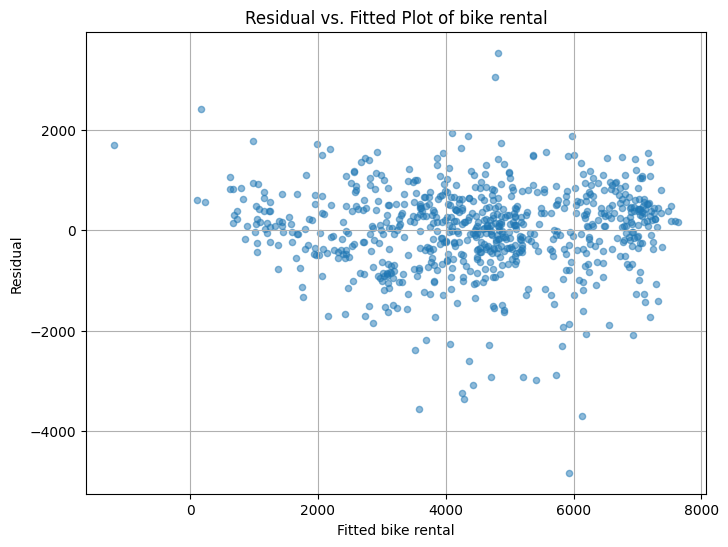

In [49]:
#residual analysis #error 应该在0附近
plt.figure(figsize=(8, 6))
plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid, alpha = 0.5, s=20)
plt.xlabel('Fitted bike rental')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of bike rental')
plt.grid(True)
plt.show()

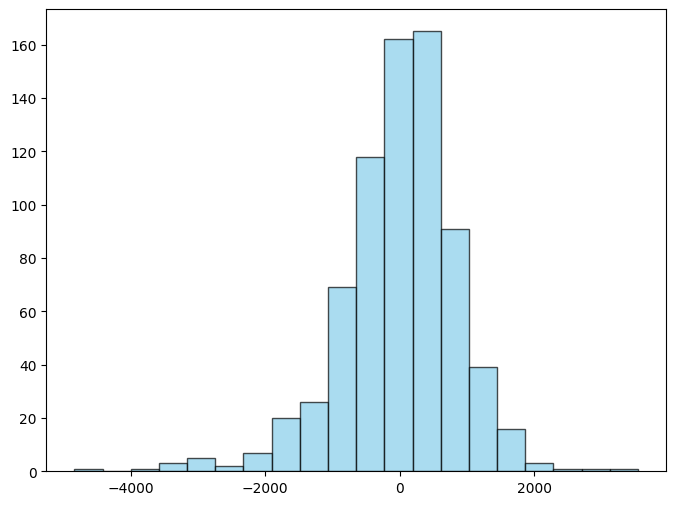

In [51]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(model_bike_rental.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.show()

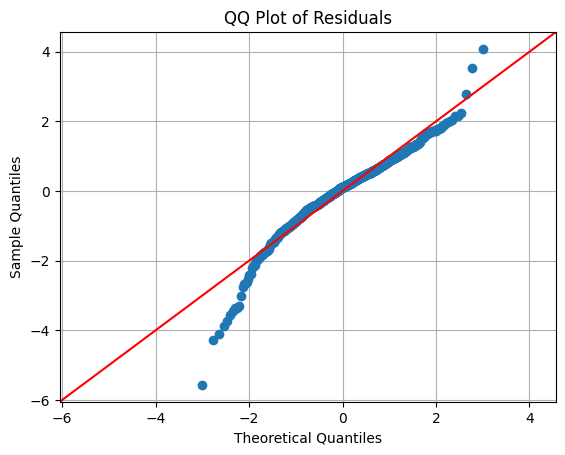

In [52]:
# (optional) the QQ plot of residuals
fig = sm.qqplot(model_bike_rental.resid, fit=True, line="45")
plt.title('QQ Plot of Residuals')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

In [22]:
#prediction
#预测 若x=150 则 有多少Y
#predict x要为df
X_new = pd.DataFrame({'greenery': [150]})
X_new.head()
reg_wb_green.predict(X_new)

0    7.765794
dtype: float64